## Generate 1000 random phenotypes with 40 PCs
This notebook is used to generate 1000 random phenotypes with 40 PCs using the UK Biobank dataset.

Reference tutorials:
1. https://dnanexus.gitbook.io/uk-biobank-rap/science-corner/gwas-using-alzheimers-disease#selecting-participant-fields-by-field-index-instance-index-array-index
2. https://dnanexus.gitbook.io/uk-biobank-rap/science-corner/end-to-end-target-discovery-with-gwas-and-phewas

In [1]:
# instance type used: 

# Import packages 
import dxpy
import subprocess

# Automatically discover dispensed dataset ID and load the dataset 
dispensed_dataset_id = dxpy.find_one_data_object(typename='Dataset', name='app*.dataset', folder='/', name_mode='glob')['id']

# Get project ID
project_id = dxpy.find_one_project()["id"]
dataset = (':').join([project_id, dispensed_dataset_id])

cmd = ["dx", "extract_dataset", dataset, "-ddd", "--delimiter", ","]
subprocess.check_call(cmd)

0

In [2]:
import glob
import os
import pandas as pd

path = os.getcwd()
data_dict_csv = glob.glob(os.path.join(path, "*.data_dictionary.csv"))[0]
data_dict_df = pd.read_csv(data_dict_csv)
data_dict_df.head()

/tmp/ipykernel_968/2755469627.py:7: DtypeWarning: Columns (4,7,8,9,10,15) have mixed types. Specify dtype option on import or set low_memory=False.
  data_dict_df = pd.read_csv(data_dict_csv)


,entity,name,type,primary_key_type,coding_name,concept,description,folder_path,is_multi_select,is_sparse_coding,linkout,longitudinal_axis_type,referenced_entity_field,relationship,title,units
0,participant,eid,string,global,NaN,NaN,NaN,Participant Information,NaN,NaN,NaN,NaN,NaN,NaN,Participant ID,NaN
1,participant,p3_i0,integer,NaN,NaN,NaN,NaN,Assessment centre > Procedural metrics > Proce...,NaN,NaN,http://biobank.ctsu.ox.ac.uk/crystal/field.cgi...,NaN,NaN,NaN,Verbal interview duration | Instance 0,seconds
2,participant,p3_i1,integer,NaN,NaN,NaN,NaN,Assessment centre > Procedural metrics > Proce...,NaN,NaN,http://biobank.ctsu.ox.ac.uk/crystal/field.cgi...,NaN,NaN,NaN,Verbal interview duration | Instance 1,seconds
3,participant,p3_i2,integer,NaN,NaN,NaN,NaN,Assessment centre > Procedural metrics > Proce...,NaN,NaN,http://biobank.ctsu.ox.ac.uk/crystal/field.cgi...,NaN,NaN,NaN,Verbal interview duration | Instance 2,seconds
4,participant,p3_i3,integer,NaN,NaN,NaN,NaN,Assessment centre > Procedural metrics > Proce...,NaN,NaN,http://biobank.ctsu.ox.ac.uk/crystal/field.cgi...,NaN,NaN,NaN,Verbal interview duration | Instance 3,seconds


In [3]:
from distutils.version import LooseVersion

def field_names_for_ids(field_id):
    field_names = ["eid"]
    for _id in field_id:
        select_field_names = list(data_dict_df[data_dict_df.name.str.match(r'^p{}(_i\d+)?(_a\d+)?$'.format(_id))].name.values)
        field_names += select_field_names
    field_names = sorted([field for field in field_names], key=lambda n: LooseVersion(n))
        
    field_names = [f"participant.{f}" for f in field_names]
    return ",".join(field_names)

field_ids = ['31', '21022', '22001', '22006', '22009', '22019', '22021', '22027',
             '41270', '20107', '2946', '1807',
             '20110', '3526', '1845']
field_names = field_names_for_ids(field_ids)

/tmp/ipykernel_968/2450282763.py:8: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  field_names = sorted([field for field in field_names], key=lambda n: LooseVersion(n))


In [4]:
cmd = ["dx", "extract_dataset", dataset, "--fields", field_names, "--delimiter", ",", "--output", "extracted_data.sql", "--sql"]
subprocess.check_call(cmd)

import pyspark

sc = pyspark.SparkContext()
spark = pyspark.sql.SparkSession(sc)

with open("extracted_data.sql", "r") as file:
    retrieve_sql=""
    for line in file: 
        retrieve_sql += line.strip()  
             
temp_df = spark.sql(retrieve_sql.strip(";"))
pdf = temp_df.toPandas()

In [5]:
#Displays first three rows of table
pdf.head(3)

,participant.eid,participant.p31,participant.p1807_i0,participant.p1807_i1,participant.p1807_i2,participant.p1807_i3,participant.p1845_i0,participant.p1845_i1,participant.p1845_i2,participant.p1845_i3,...,participant.p22009_a35,participant.p22009_a36,participant.p22009_a37,participant.p22009_a38,participant.p22009_a39,participant.p22009_a40,participant.p22019,participant.p22021,participant.p22027,participant.p41270
0,1000011,1,75.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-2.504300,3.84603,-1.843560,-1.538320,-6.37522,-6.15284,NaN,0.0,NaN,None
1,1000047,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-0.299494,1.27374,2.769230,0.286222,4.95198,-1.22526,NaN,0.0,NaN,None
2,1000190,1,79.0,NaN,NaN,NaN,89.0,NaN,NaN,NaN,...,-1.361010,-6.86181,-0.962837,1.923140,2.06460,-3.98545,NaN,1.0,NaN,"[A099, E86, E875, E877, F419, H250, H269, I10,..."


In [6]:
# Format column headers
import re
pdf = pdf.rename(columns=lambda x: re.sub('participant.','',x))
pdf.head(3)

,eid,p31,p1807_i0,p1807_i1,p1807_i2,p1807_i3,p1845_i0,p1845_i1,p1845_i2,p1845_i3,...,p22009_a35,p22009_a36,p22009_a37,p22009_a38,p22009_a39,p22009_a40,p22019,p22021,p22027,p41270
0,1000011,1,75.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-2.504300,3.84603,-1.843560,-1.538320,-6.37522,-6.15284,NaN,0.0,NaN,None
1,1000047,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-0.299494,1.27374,2.769230,0.286222,4.95198,-1.22526,NaN,0.0,NaN,None
2,1000190,1,79.0,NaN,NaN,NaN,89.0,NaN,NaN,NaN,...,-1.361010,-6.86181,-0.962837,1.923140,2.06460,-3.98545,NaN,1.0,NaN,"[A099, E86, E875, E877, F419, H250, H269, I10,..."


In [7]:
# Extract ICD-10 Codes for AD by Patterns (G30 and F00)
codings_csv = glob.glob(os.path.join(path, "*.codings.csv"))[0]
codings_df = pd.read_csv(codings_csv)
codings_df.head()

# Collapse ICD-10 codes for Alzheimer's disease (G30* and F00*)
ad_icd_codes = list(
    codings_df[(codings_df["coding_name"] == "data_coding_19") & ((codings_df["parent_code"] == "G30") | (codings_df["parent_code"] == "F00"))]["code"])
ad_icd_codes

['F000', 'F001', 'F002', 'F009', 'G300', 'G301', 'G308', 'G309']

In [8]:
# Derive the Phenotype (AD-by-Proxy)
import ast
import numpy as np

# Replace NaN with string None for p41270

# Note: eval will return Nonetype for string "None"
pdf["p41270"] = pdf["p41270"].replace(np.nan, "None")


# Get each participant's hospital inpatient records in ICD10 Diagnoses
def icd10_codes(row):
    icd10_codes = row['p41270'] or []
    return list( set(icd10_codes) )

pdf['icd10_codes'] = pdf.apply(icd10_codes, axis=1)

# If the participant has any of the ICD-10 codes for AD, record the risk to "2" 
def has_ad_icd10(row): 
    return 0 if set(row['icd10_codes']).isdisjoint(ad_icd_codes) else 2 
pdf['has_ad_icd10'] = pdf.apply(has_ad_icd10, axis=1) 


In [9]:
# Data-fields 20107 and 20110 record illnesses of each participant's father and mother. If diagnosed with AD, assign the parent's risk as "1":
pdf['illnesses_of_father'] = (
    pdf.filter(regex='p20107')
    .apply(lambda x: list(set(x.dropna().astype(str))), axis=1)
)

pdf['illnesses_of_mother'] = (
    pdf.filter(regex='p20110')
    .apply(lambda x: list(set(x.dropna().astype(str))), axis=1)
)
pdf.head(3)

,eid,p31,p1807_i0,p1807_i1,p1807_i2,p1807_i3,p1845_i0,p1845_i1,p1845_i2,p1845_i3,...,p22009_a39,p22009_a40,p22019,p22021,p22027,p41270,icd10_codes,has_ad_icd10,illnesses_of_father,illnesses_of_mother
0,1000011,1,75.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-6.37522,-6.15284,NaN,0.0,NaN,None,"[e, o, N, n]",0,"[[8, 1, -27]]","[[12, 10]]"
1,1000047,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,4.95198,-1.22526,NaN,0.0,NaN,None,"[e, o, N, n]",0,"[[1, -27]]","[[5, -17]]"
2,1000190,1,79.0,NaN,NaN,NaN,89.0,NaN,NaN,NaN,...,2.06460,-3.98545,NaN,1.0,NaN,"[A099, E86, E875, E877, F419, H250, H269, I10,...","[Z514, H250, I420, K573, R11, Z873, R060, E877...",0,"[[9, 8, 2, 1, -27]]","[[-17, -27]]"


In [10]:
# Get the max age between age at death and recorded age

pdf['father_age'] = pdf.filter(regex=(r'(p1807_*|p2946_*)')).max(axis=1)
pdf['mother_age'] = pdf.filter(regex=(r'(p3526_*|p1845_*)')).max(axis=1)

In [11]:
# If the parent has diagnosed with AD (code 10), record it as 1; 
# else assign parent's AD risk with their risk, which is their age (proportional to diff of age of 100) with minimum risk at 0.32 

def parents_ad_risk(row): 
    import numpy as np 

    father_ad_risk = 1 if 10 in row['illnesses_of_father'] else np.maximum(0.32, (100 - row['father_age'])/100)
    mother_ad_risk = 1 if 10 in row['illnesses_of_mother'] else np.maximum(0.32, (100 - row['mother_age'])/100)
    return father_ad_risk + mother_ad_risk 

pdf['parents_ad_risk'] = pdf.apply(parents_ad_risk, axis=1) 
pdf['ad_risk_by_proxy'] = pdf[['has_ad_icd10','parents_ad_risk']].max(axis=1) 
pdf[['ad_risk_by_proxy','parents_ad_risk','has_ad_icd10']].head() 

,ad_risk_by_proxy,parents_ad_risk,has_ad_icd10
0,0.64,0.64,0
1,0.86,0.86,0
2,0.64,0.64,0
3,0.75,0.75,0
4,0.64,0.64,0


## Perform Sample QC and Determine Phenotype

In [ ]:
pdf_qced = pdf[
           (pdf['p31'] == pdf['p22001']) & # Filter in sex and genetic sex are the same
           (pdf['p22006']==1) &            # in_white_british_ancestry_subset
           (pdf['p22019'].isnull()) &      # Not Sex chromosome aneuploidy
           (pdf['p22021']!=10) &           # Not Ten or more third-degree relatives identified (not 'excess_relatives')
           (pdf['p22027'].isnull()) &      # Not het_missing_outliers
        #    ((pdf['father_age'].notnull()) & (pdf['father_age']>0)) &  # There is father's age
        #    ((pdf['mother_age'].notnull()) & (pdf['mother_age']>0)) &  # There is mother's age
        #    (pdf['illnesses_of_father'].apply(lambda x:(-11 not in x and -13 not in x))) &  # Filter out "do not know" or "prefer not to answer" father illness
        #    (pdf['illnesses_of_mother'].apply(lambda x:(-11 not in x and -13 not in x)))    # Filter out "do not know" or "prefer not to answer" mother illness
]

In [13]:
# This is the number of samples we have in our table 

pdf_qced.shape[0]

389479

<AxesSubplot: >

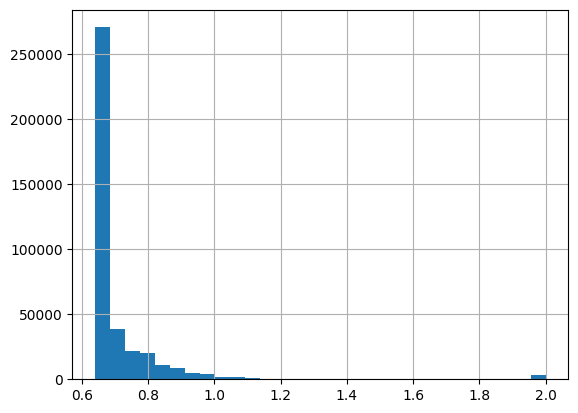

In [14]:
# Visualize the distribution of the phenotype we derived
pdf_qced['ad_risk_by_proxy'].hist(bins=30)

In [15]:
# All participants have ad_risk_by_proxy are considered cases (1) and the rest are considered as controls (0)

# pandas warning:
# pdf_qced['ad_by_proxy'] = np.where(pdf_qced['ad_risk_by_proxy']>= 1, 1, 0)
pdf_qced = pdf_qced.copy()
pdf_qced['ad_by_proxy'] = np.where(pdf_qced['ad_risk_by_proxy'] >= 1, 1, 0)
pdf_qced['ad_by_proxy'].value_counts()

0    379909
1      9570
Name: ad_by_proxy, dtype: int64

## Rename columns and organize it in format suitable for PLINK and regenie

In [16]:
# Rename columns for better human readability 
import re
 
pdf_qced = pdf_qced.rename(columns=lambda x: re.sub('p22009_a','pc',x)) 
pdf_qced = pdf_qced.rename(columns={'eid':'IID', 'p31': 'sex', 'p21022': 'age', 'p22006': 'ethnic_group', 
'p22019': 'sex_chromosome_aneuploidy', 
'p22021': 'kinship_to_other_participants', 
'p22027': 'outliers_for_heterozygosity_or_missing'})
 
# Add FID column -- required input format for regenie 
pdf_qced['FID'] = pdf_qced['IID'] 

# Join list of parent's illness -- making it a single string format rather than list format 
pdf_qced['illnesses_of_father'] = pdf_qced['illnesses_of_father'].apply(lambda x: [str(i) for i in x if i]).str.join(",").replace(r'^\s*$', np.nan, regex=True)
pdf_qced['illnesses_of_mother'] = pdf_qced['illnesses_of_mother'].apply(lambda x: [str(i) for i in x if i]).str.join(",").replace(r'^\s*$', np.nan, regex=True)

# Join list of ICD10 code -- making it a single string format rather than list format
pdf_qced['icd10_codes'] = pdf_qced['icd10_codes'].apply(lambda x: 'NA' if x is None else ",".join([str(i) for i in x]))
 
# Create a phenotype table from our QCed data 
pdf_phenotype = pdf_qced[['FID', 'IID', 'sex', 'age', 
'ad_by_proxy', 'ad_risk_by_proxy', 
'icd10_codes', 'has_ad_icd10', 
'ethnic_group', 'sex_chromosome_aneuploidy', 
'kinship_to_other_participants', 
'outliers_for_heterozygosity_or_missing', 
'illnesses_of_father', 'illnesses_of_mother', 
'father_age', 'mother_age', 'parents_ad_risk'] + [f'pc{i}' for i in range(1, 41)]]
# pdf_phenotype.to_csv('ad_risk_by_proxy_wes.phe', sep='\t', na_rep='NA', index=False, quoting=3 )

In [17]:
pdf_phenotype.head(5)

,FID,IID,sex,age,ad_by_proxy,ad_risk_by_proxy,icd10_codes,has_ad_icd10,ethnic_group,sex_chromosome_aneuploidy,...,pc31,pc32,pc33,pc34,pc35,pc36,pc37,pc38,pc39,pc40
0,1000011,1000011,1,61,0,0.64,"e,o,N,n",0,1.0,NaN,...,-3.398190,-1.986990,-0.278006,5.296840,-2.50430,3.846030,-1.843560,-1.53832,-6.37522,-6.152840
2,1000190,1000190,1,65,0,0.64,"Z514,H250,I420,K573,R11,Z873,R060,E877,I451,N1...",0,1.0,NaN,...,1.640270,-1.359230,-0.404444,-6.350250,-1.36101,-6.861810,-0.962837,1.92314,2.06460,-3.985450
4,1000258,1000258,1,59,0,0.64,"J439,D45,M720,I279,K409,F171,Z720,Z721,D751,J4...",0,1.0,NaN,...,4.426890,2.029280,-2.469000,0.345487,-2.00417,-0.310548,-2.102350,5.66629,2.78945,-4.480020
5,1000354,1000354,1,45,0,0.79,"e,o,N,n",0,1.0,NaN,...,0.877565,-0.541459,-3.287930,0.752287,2.52221,-2.387540,-0.231804,-4.87371,-0.28163,0.339565
6,1000467,1000467,0,62,0,0.64,"S7210,J439,B962,Z038,H544,S8280,Z470,T931,T814...",0,1.0,NaN,...,-1.809870,3.858570,5.884630,-3.459750,2.99685,-1.598430,3.379620,3.09292,3.73815,-3.683930


## Select only samples that have imputed data available and save phenotype table as CSV

In [18]:
imputation_folder = 'Imputation from genotype (GEL)'
imputation_field_id = '21008' # (Genomics England)

# Get imputed data
path_to_impute_file = f'/mnt/project/Bulk/Imputation/{imputation_folder}/ukb{imputation_field_id}_c1_b0_v1.sample'
sample_file = pd.read_csv(
    path_to_impute_file,
    delimiter='\s',
    header=0,
    names=['FID', 'IID', 'missing', 'sex'],
    engine='python',
)
# Intersect the phenotype file and the imputed .sample file
# to generate phenotype DataFrame for only samples included in the imputed data
# Ensure the IID columns are of the same type
pdf_phenotype['IID'] = pdf_phenotype['IID'].astype(str)
sample_file['IID'] = sample_file['IID'].astype(str)

# Now perform the join
intersected_df = pdf_phenotype.join(
    sample_file.set_index('IID'), on='IID', rsuffix='_sample', how='inner'
)

# Drop unnecessary columns
intersected_df.drop(
    columns=['FID_sample', 'missing', 'sex_sample'],
    axis=1,
    inplace=True,
    errors='ignore',
)


/tmp/ipykernel_968/2417105991.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pdf_phenotype['IID'] = pdf_phenotype['IID'].astype(str)


In [19]:
intersected_df.head(5)

,FID,IID,sex,age,ad_by_proxy,ad_risk_by_proxy,icd10_codes,has_ad_icd10,ethnic_group,sex_chromosome_aneuploidy,...,pc31,pc32,pc33,pc34,pc35,pc36,pc37,pc38,pc39,pc40
0,1000011,1000011,1,61,0,0.64,"e,o,N,n",0,1.0,NaN,...,-3.398190,-1.986990,-0.278006,5.296840,-2.50430,3.846030,-1.843560,-1.53832,-6.37522,-6.152840
2,1000190,1000190,1,65,0,0.64,"Z514,H250,I420,K573,R11,Z873,R060,E877,I451,N1...",0,1.0,NaN,...,1.640270,-1.359230,-0.404444,-6.350250,-1.36101,-6.861810,-0.962837,1.92314,2.06460,-3.985450
4,1000258,1000258,1,59,0,0.64,"J439,D45,M720,I279,K409,F171,Z720,Z721,D751,J4...",0,1.0,NaN,...,4.426890,2.029280,-2.469000,0.345487,-2.00417,-0.310548,-2.102350,5.66629,2.78945,-4.480020
5,1000354,1000354,1,45,0,0.79,"e,o,N,n",0,1.0,NaN,...,0.877565,-0.541459,-3.287930,0.752287,2.52221,-2.387540,-0.231804,-4.87371,-0.28163,0.339565
6,1000467,1000467,0,62,0,0.64,"S7210,J439,B962,Z038,H544,S8280,Z470,T931,T814...",0,1.0,NaN,...,-1.809870,3.858570,5.884630,-3.459750,2.99685,-1.598430,3.379620,3.09292,3.73815,-3.683930


In [20]:
intersected_df.shape

(389479, 57)

### Add Random Phenotypes

In [21]:
import numpy as np

N_PHENOTYPES = 1000
N_SAMPLES = 10000

data = intersected_df.sample(n=N_SAMPLES, random_state=123)
data.head(5)

,FID,IID,sex,age,ad_by_proxy,ad_risk_by_proxy,icd10_codes,has_ad_icd10,ethnic_group,sex_chromosome_aneuploidy,...,pc31,pc32,pc33,pc34,pc35,pc36,pc37,pc38,pc39,pc40
491887,5507516,5507516,1,64,0,0.64,"R031,K573,R42,K635,K621,E119,Z855,I842,C442,E8...",0,1.0,NaN,...,-1.347190,-0.348585,-5.859300,1.522720,1.69443,2.819020,-3.05534,3.61349,-6.83692,0.506155
168951,4449508,4449508,1,68,0,0.64,"Z885,I849,Z922,R11,K573,K922,Z092,R074,Z888,Q2...",0,1.0,NaN,...,-3.338320,-1.256970,-4.663410,0.073669,-1.11743,-0.300156,2.74387,2.17337,1.23904,3.723800
331131,2510504,2510504,0,60,0,0.64,"M5416,K589,F329,R194,R15,F171,M169,E780,M754,F419",0,1.0,NaN,...,0.355592,-0.572851,3.881550,-1.032470,4.65727,-3.436040,-2.84119,1.53241,6.54497,1.723020
271848,4563542,4563542,0,45,0,0.87,"T814,W109,M1999,K029,Y838,R69,M2553,T922,Z470,...",0,1.0,NaN,...,2.702600,1.018400,-1.218810,4.325060,2.44847,-0.814664,-2.96783,-3.37105,-2.25950,3.783680
324345,2170567,2170567,0,45,0,0.64,"Z900,N812,R194,Z966,M179,M543,R103,Z907,Y400,Z...",0,1.0,NaN,...,7.740350,1.194570,-0.698582,2.086440,-1.95051,-0.769890,3.18943,2.21498,-1.59685,2.888820


In [25]:
# Create random state
random_state = 123
data_with_rand_pheno = pd.DataFrame(
    {f"pheno{i}": rs.normal(size=len(data)) for i in range(N_PHENOTYPES)},
    index=data.index
)

# Concatenate the original data with random phenotypes
data_with_rand_pheno = pd.concat([data, data_with_rand_pheno], axis=1)

# Old code with warnings:
# data = data.assign(**random_phenos)

In [26]:
data_with_rand_pheno.head()

,FID,IID,sex,age,ad_by_proxy,ad_risk_by_proxy,icd10_codes,has_ad_icd10,ethnic_group,sex_chromosome_aneuploidy,...,pheno990,pheno991,pheno992,pheno993,pheno994,pheno995,pheno996,pheno997,pheno998,pheno999
491887,5507516,5507516,1,64,0,0.64,"R031,K573,R42,K635,K621,E119,Z855,I842,C442,E8...",0,1.0,NaN,...,0.718638,-0.110123,0.737745,-0.633641,1.216991,-1.420129,-1.284943,1.346239,0.540493,0.277201
168951,4449508,4449508,1,68,0,0.64,"Z885,I849,Z922,R11,K573,K922,Z092,R074,Z888,Q2...",0,1.0,NaN,...,0.658072,0.050963,-0.525429,0.230989,0.044333,1.127648,-0.800838,-0.573650,-0.682659,-0.851211
331131,2510504,2510504,0,60,0,0.64,"M5416,K589,F329,R194,R15,F171,M169,E780,M754,F419",0,1.0,NaN,...,0.328091,0.521500,0.379871,0.443657,-0.235752,0.667793,-0.995434,-1.518953,-0.428636,-1.174860
271848,4563542,4563542,0,45,0,0.87,"T814,W109,M1999,K029,Y838,R69,M2553,T922,Z470,...",0,1.0,NaN,...,0.514931,0.815854,0.693793,-0.229906,-1.445770,-0.363390,-0.844590,0.675575,0.951003,2.370887
324345,2170567,2170567,0,45,0,0.64,"Z900,N812,R194,Z966,M179,M543,R103,Z907,Y400,Z...",0,1.0,NaN,...,0.355497,1.266717,-0.037256,-0.825732,0.816319,0.907230,1.142129,-0.086770,0.080041,-0.467167


## Save the result

In [27]:
data_with_rand_pheno.to_csv('random_phenotypes_df_40_pcs.phe', sep='\t', na_rep='NA', index=False, quoting=3 )


In [32]:
output_dir = "/phenoplier/null_sim/00-data/"

cmd = ["dx", "upload", "random_phenotypes_df_40_pcs.phe", "--path", output_dir]
subprocess.check_call(cmd)

0